# Experiment plotting

This notebook contains the code for plotting results for the different experiments.
When run for the first time for a town, condensed summary files are being created which strongly speed up subsequent generations of plots from the same summaries. It is possible to create the plots only from the condensed summaries located in 'summaries/condensed_summaries'.
Note that this works for all experiments but the Rt plots, which still require the full summary file.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import pickle
import itertools
from lib.measures import *
from lib.experiment import Experiment, Plot, Result, get_properties, load_summary_list, load_summary
from lib.data import collect_data_from_df
from lib.calibrationSettings import calibration_lockdown_dates, calibration_start_dates, calibration_mob_paths
from lib.calibrationFunctions import get_calibrated_params, downsample_cases
import lib.plot as lib_plot
from lib.plot import Plotter
import matplotlib.pyplot as plt
from lib.summary import load_condensed_summary, get_tracing_probability
from matplotlib import colors
import matplotlib
from collections import defaultdict

In [3]:
figformat = 'tiff'

In [4]:
commithash = 'baf7764'

baseline_colors = ['#31a354', '#74c476', '#006d2c']
spect_colors = ['#08519c', '#3182bd', '#6baed6', '#bdd7e7']
pancast_colors = ['#bd0026', '#f03b20', '#fd8d3c', '#fecc5c', '#ffffb2']

# Reduction of different quantities compared to baseline

In [5]:
def plot_relative_reduction(*, country, area, mode, ps_adoption, beacon_proportions, beacon_mode='visit_freq', 
                            manual_tracing=True, show_reduction=True, show_spect_with_beacons=False,
                            colors=None, log_yscale=False, figsize=None,
                            isolation_cap=None, ylim=None, box_plot=False, legend_is_left=True,
                            show_significance=None, sig_options=None, commithash=None):
    
    ps_adoption = np.sort(ps_adoption)
    
    if figsize is None:
        figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL
        
    if manual_tracing:
        p_recall = 0.1
        p_manual_reachability = 0.5
    else:
        p_recall = 0.0
        p_manual_reachability = 0.0
    delta_manual_tracing = 0.0
        
    if mode == 'r_eff':
        if area == 'TU':
            from lib.settings.town_settings_tubingen import town_population
        else:
            raise NotImplementedError('Specify town population')
    else:
        town_population = None
        
    if isolation_cap is not None:
        is_site_info = '-siteinfo'
        extension = (f'-beta_dispersion=10.0'
                    f'-isolation_cap={isolation_cap}'
                    f'-normalization=1.75')
        baseline_extension = (f'-beta_dispersion=10.0'
                    f'-isolation_cap=0.0'
                    f'-normalization=1.75')
    else:
        is_site_info = ''
        extension = ''
        baseline_extension = ''
        

        
    if ylim is None:
        if mode == 'r_eff' and show_reduction:
            ylim = (0.0, 50)
        elif mode == 'r_eff' and not show_reduction:
            ylim= (1.0, 3.7)
            
    
    plot_filename = (f'comparison{is_site_info}-{mode}-{country}-{area}'
                    f'-reduction={show_reduction}'
                    f'-box_plot={box_plot}'
                    f'-beacon_mode={beacon_mode}'
                    f'-manual_tracing={manual_tracing}'
                    f'-p2p+beacons={show_spect_with_beacons}')
    paths = [
                [f'spect-tracing{is_site_info}-{country}-{area}-{commithash}/'
                 f'spect-tracing{is_site_info}-{country}-{area}'
                 f'-p_adoption={p_adoption}'
                 f'-p_recall={p_recall}'
                 f'-p_manual_reachability={p_manual_reachability}'
                 f'-delta_manual_tracing={delta_manual_tracing}'
                 f'{extension}'
                 '.pk' for p_adoption in ps_adoption]
            ]
    titles = ['SPECTS']
    
    for beacon_proportion in beacon_proportions:
        paths.append([f'pancast-tracing{is_site_info}-{country}-{area}-{commithash}/'
                      f'pancast-tracing{is_site_info}-{country}-{area}'
                      f'-p_adoption={p_adoption}'
                      f'-beacon_proportion={beacon_proportion}'
                      f'-beacon_mode={beacon_mode}'
                      f'-p2p_beacon={show_spect_with_beacons}'
                      f'-p_recall={p_recall}'
                      f'-p_manual_reachability={p_manual_reachability}'
                      f'-delta_manual_tracing={delta_manual_tracing}'
                      f'{extension}'
                      '.pk' for p_adoption in ps_adoption])
                     
        titles.append(f'PanCast, beacons at {int(beacon_proportion*100)}\% of sites')
    
    
    if manual_tracing:
        titles.append('Only manual tracing')
    else:
        titles.append('No tracing')
    
    
    if show_spect_with_beacons:
        # titles = [f'SPECTS + beacons at {int(beacon_proportion*100)}\% of sites' for beacon_proportion in ([0] + beacon_proportions[::-1])]
        titles = [f'SPECTS + {int(beacon_proportion*100)}\% beacons' for beacon_proportion in ([0] + beacon_proportions[::-1])]
        new_paths = paths[1:]
        paths = [paths[0]] + new_paths[::-1]
        # colors = ['#377eb8', '#fecc5c', '#fd8d3c', '#f03b20', '#bd0026']
        colors = ['#377eb8', '#fecc5c', '#fd8d3c', '#f03b20', '#bd0026']
        if manual_tracing:
            titles.append('Only manual tracing')
        else:
            titles.append('No tracing')


    if isolation_cap is not None:
        # Always normalize with no MT baseline
        p_recall = 0.0
        p_manual_reachability = 0.0
        
    baseline_path = (f'spect-tracing{is_site_info}-{country}-{area}-{commithash}/'
                     f'spect-tracing{is_site_info}-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall={p_recall}'
                     f'-p_manual_reachability={p_manual_reachability}'
                     f'-delta_manual_tracing={delta_manual_tracing}'
                     f'{extension}'
                     f'.pk')

    plotter = Plotter()
    plotter.compare_peak_reduction(path_list=paths, 
                                   baseline_path=baseline_path, 
                                   ps_adoption=ps_adoption,
                                   area_population=town_population,
                                   labels=titles,
                                   mode=mode,
                                   show_reduction=show_reduction,
                                   box_plot=box_plot,
                                   log_xscale=True,
                                   log_yscale=log_yscale,
                                   ylim=ylim,
                                   show_significance=show_significance,
                                   sig_options=sig_options,
                                   colors=colors,
                                   filename=plot_filename,
                                   figsize=figsize,
                                   figformat='neurips-double',
                                   legend_is_left=legend_is_left,
                                   format=figformat)


## Reduction of infections

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
p-value:  0.0
p-value:  0.0
p-value:  0.0
p-value:  0.0006879148033733795
p-value:  0.0
p-value:  0.0
p-value:  2.220446049250313e-15
p-value:  0.06637223832179662
p-value:  0.0
p-value:  0.0
p-value:  4.9887913800006345e-09
p-value:  0.0
p-value:  0.6770447001722859
p-value:  0.0
p-va

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
p-value:  0.7777963681357782
p-value:  0.07067376387153135
p-value:  8.959594364199575e-07
p-value:  1.59601221128014e-11
p-value:  0.752900247114985
p-value:  3.901350940083148e-07
p-value:  0.0
p-value:  0.0
p-value:  0.6288089419332659
p-value:  0.0
p-value:  0.0
p-value:  0.0
p-val

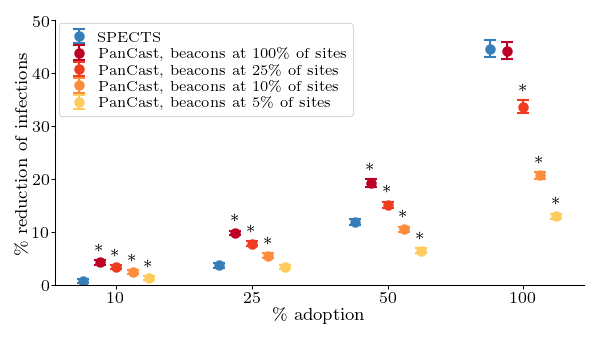

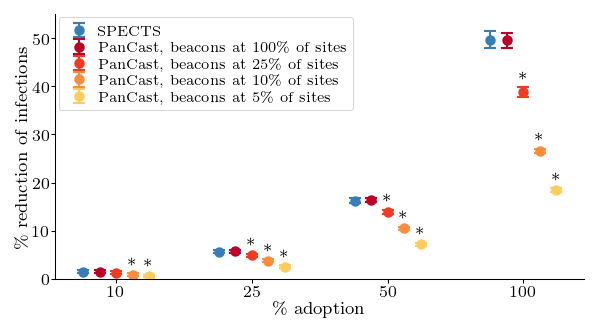

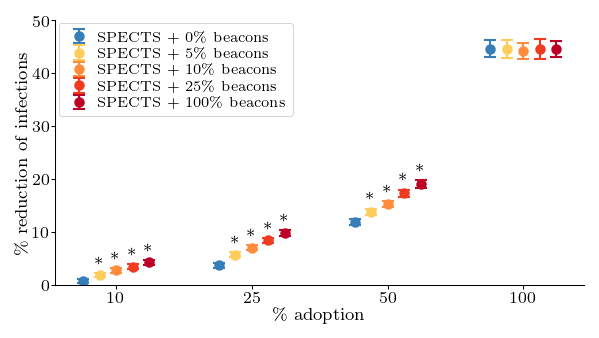

In [6]:
LINE_WIDTH = 7.0
COL_WIDTH = 3.333
figsize = (1.2 * LINE_WIDTH / 2, 1.2 * LINE_WIDTH / 3 * 4.5/6)

sig_options={'height': 1.0, 'same_height': False}


# Main Figure 2a, manual tracing
plot_relative_reduction(
    country='GER', 
    area='TU', 
    mode='cumu_infected',
    ps_adoption=[1.0, 0.5, 0.25, 0.1],
    beacon_proportions=[1.0, 0.25, 0.1, 0.05],
    beacon_mode='visit_freq',
    manual_tracing=True,
    show_spect_with_beacons=False,
    show_significance='no_bars',
    sig_options=sig_options,
    box_plot=True,
    ylim=[0,50],
    figsize=figsize,
    commithash=commithash
)


# SI Figure 5a: without manual tracing
plot_relative_reduction(
    country='GER', 
    area='TU', 
    mode='cumu_infected',
    ps_adoption=[1.0, 0.5, 0.25, 0.1],
    beacon_proportions=[1.0, 0.25, 0.1, 0.05],
    manual_tracing=False,
    show_spect_with_beacons=False,
    show_significance='no_bars',
    sig_options=sig_options,
    box_plot=True,
    ylim=[0,55],
    figsize=figsize,
    commithash=commithash
)


# SI Figure 7a, interoperability
plot_relative_reduction(
    country='GER', 
    area='TU', 
    mode='cumu_infected',
    ps_adoption=[1.0, 0.5, 0.25, 0.1],
    beacon_proportions=[1.0, 0.25, 0.1, 0.05],
    manual_tracing=True,
    show_spect_with_beacons=True,
    show_significance='no_bars',
    sig_options=sig_options,
    box_plot=True,
    ylim=[0,50],
    figsize=figsize,
    commithash=commithash
)

!bash crop_pdfs.sh plots/comparison-*.pdf

## R_eff plots

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previou

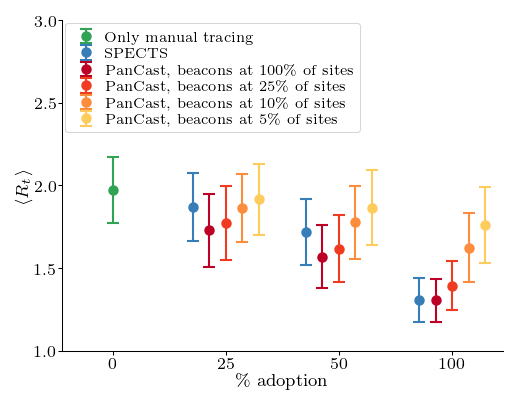

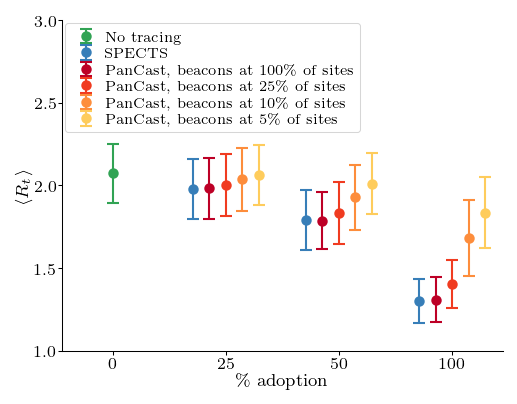

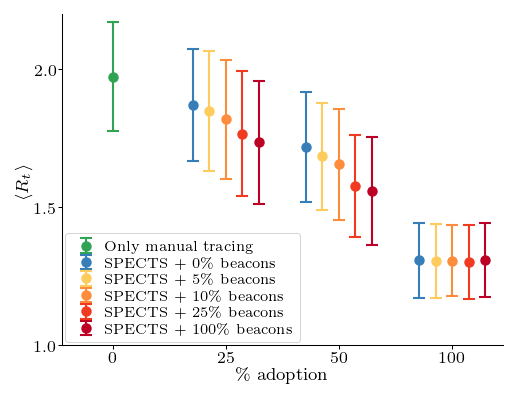

In [7]:
sig_bars = {'lhs_xshift': 0.0, 
            'rhs_xshift': 0.0, 
            'height': 0.07}

LINE_WIDTH = 7.0
COL_WIDTH = 3.333
figsize = (0.5*LINE_WIDTH,  1.5 * LINE_WIDTH / 3 * 4.5/6)


# Main Figure 2c, manual tracing panel
plot_relative_reduction(
    country='GER', 
    area='TU', 
    mode='r_eff',
    ps_adoption=[1.0, 0.5, 0.25],
    beacon_proportions=[1.0, 0.25, 0.1, 0.05],
    beacon_mode='visit_freq',
    manual_tracing=True,
    figsize=figsize,
    show_spect_with_beacons=False,
    show_reduction=False,
    ylim = (1.0, 3.0),
    box_plot=True,
    commithash=commithash
)


# SI Figure 5c, no manual tracing
plot_relative_reduction(
    country='GER', 
    area='TU', 
    mode='r_eff',
    ps_adoption=[1.0, 0.5, 0.25],
    beacon_proportions=[1.0, 0.25, 0.1, 0.05],
    beacon_mode='visit_freq',
    manual_tracing=False,
    show_spect_with_beacons=False,
    show_reduction=False,
    figsize=figsize,
    ylim = (1.0, 3.0),
    box_plot=True,
    commithash=commithash,
)


# SI Figure 7c, interoperability
plot_relative_reduction(
    country='GER', 
    area='TU', 
    mode='r_eff',
    ps_adoption=[1.0, 0.5, 0.25],
    beacon_proportions=[1.0, 0.25, 0.1, 0.05],
    manual_tracing=True,
    show_spect_with_beacons=True,
    box_plot=True,
    figsize=figsize,
    ylim=[1.0,2.2],
    legend_is_left='outside',
    show_reduction=False,
    commithash=commithash
)

!bash crop_pdfs.sh plots/comparison-*.pdf

## SI: Environmental information, isolation caps

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previou

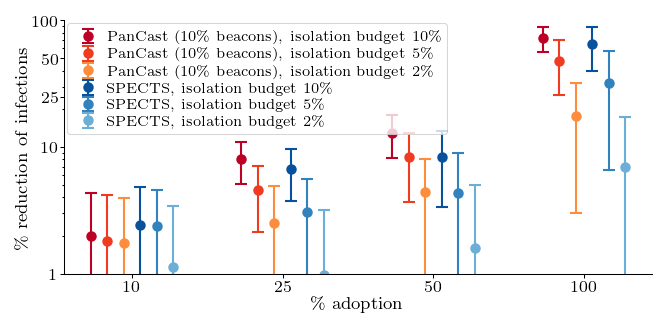

In [8]:
def plot_relative_reduction_isolation_cap_multi_summary(*, country, area, mode, ps_adoption, beacon_proportion, beacon_mode='visit_freq', 
                            manual_tracing=True, show_reduction=True, show_spect_with_beacons=False,
                            isolation_caps=None, ylim=None, box_plot=False, summary_indices=[1,2,3,4,5],
                            sig_bars=False, commithash=None):
    
    ps_adoption = np.sort(ps_adoption)
    if box_plot:
        LINE_WIDTH = 7.0
        COL_WIDTH = 3.333
        # figsize = (LINE_WIDTH*2/3, COL_WIDTH*2/3)
        figsize = (LINE_WIDTH * 8/12, 1.15 * LINE_WIDTH / 3 * 4.5/6)
    else:
        figsize = lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL
    
    if manual_tracing:
        p_recall = 0.1
        p_manual_reachability = 0.5
    else:
        p_recall = 0.0
        p_manual_reachability = 0.0
        
    delta_manual_tracing = 0.0
        
    if mode == 'r_eff':
        if area == 'TU':
            from lib.settings.town_settings_tubingen import town_population
        else:
            raise NotImplementedError('Specify town population')
    else:
        town_population = None
        
        
    if ylim is None:
        if mode == 'r_eff' and show_reduction:
            ylim = (0.0, 50)
        elif mode == 'r_eff' and not show_reduction:
            ylim= (1.0, 3.5)
            
    
    plot_filename = (f'comparison-isolation-caps-multi-{mode}-{country}-{area}'
                    f'-reduction={show_reduction}'
                    f'-box_plot={box_plot}'
                    f'-beacon_mode={beacon_mode}'
                    f'-manual_tracing={manual_tracing}'
                    f'-p2p+beacons={show_spect_with_beacons}')
    
    
    paths = []
    titles = []
    
    
    for cap in isolation_caps:
        paths.append([[f'pancast-tracing-siteinfo-{idx}-{country}-{area}-{commithash}/'
                      f'pancast-tracing-siteinfo-{idx}-{country}-{area}'
                      f'-p_adoption={p_adoption}'
                      f'-beacon_proportion={beacon_proportion}'
                      f'-beacon_mode={beacon_mode}'
                      f'-p2p_beacon={show_spect_with_beacons}'
                      f'-p_recall={p_recall}'
                      f'-p_manual_reachability={p_manual_reachability}'
                      f'-delta_manual_tracing={delta_manual_tracing}'
                      f'-beta_dispersion=10.0'
                      f'-isolation_cap={cap}'
                      f'-normalization=1.75'
                      '.pk' for idx in summary_indices]
                      for p_adoption in ps_adoption])
                     
        #titles.append(f'PanCast, {int(beacon_proportion*100)}\% beacons, isolation budget {int(cap*100)}\%')
        titles.append(f'PanCast ({int(beacon_proportion*100)}\% beacons), isolation budget {int(cap*100)}\%')



        
    for cap in isolation_caps:
        paths.append([[f'spect-tracing-siteinfo-{idx}-{country}-{area}-{commithash}/'
                     f'spect-tracing-siteinfo-{idx}-{country}-{area}'
                     f'-p_adoption={p_adoption}'
                     f'-p_recall={p_recall}'
                     f'-p_manual_reachability={p_manual_reachability}'
                     f'-delta_manual_tracing={delta_manual_tracing}'
                     f'-beta_dispersion=10.0'
                     f'-isolation_cap={cap}'
                      f'-normalization=1.75'
                     '.pk' for idx in summary_indices]
                      for p_adoption in ps_adoption])
        
        titles.append(f'SPECTS, isolation budget {int(cap*100)}\%')
        
    baseline_path = [f'spect-tracing-siteinfo-{idx}-{country}-{area}-{commithash}/'
                     f'spect-tracing-siteinfo-{idx}-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall=0.0'#{p_recall}'
                     f'-p_manual_reachability=0.0'#{p_manual_reachability}'
                     f'-delta_manual_tracing={delta_manual_tracing}'
                     f'-beta_dispersion=10.0'
                     f'-isolation_cap=0.0'
                     f'-normalization=1.75'
                     f'.pk'  for idx in summary_indices]

    
    colors = ['#bd0026', '#f03b20', '#fd8d3c', '#08519c', '#3182bd', '#6baed6', ]
    
    plotter = Plotter()
    plotter.compare_peak_reduction(path_list=paths, 
                                   baseline_path=baseline_path, 
                                   ps_adoption=ps_adoption,
                                   area_population=town_population,
                                   labels=titles,
                                   mode=mode,
                                   show_reduction=show_reduction,
                                   log_xscale=True,
                                   log_yscale=True,
                                   sig_options=sig_options,
                                   combine_summaries=True,
                                   ylim=ylim,
                                   colors=colors,
                                   box_plot=box_plot,
                                   filename=plot_filename,
                                   figsize=figsize,
                                   figformat='neurips-double',
                                   legend_is_left=True)


    
# SI Figure 6, environmental information, dependence on isolation caps
plot_relative_reduction_isolation_cap_multi_summary(
    country='GER', 
    area='TU', 
    mode='cumu_infected',
    ps_adoption=[1.0, 0.5, 0.25, 0.1],
    beacon_proportion=0.1,
    isolation_caps=[0.1, 0.05, 0.02],
    summary_indices=[1, 2, 3, 4, 5],
    ylim=[1.0,100],
    box_plot=True,
    sig_bars=False,
    manual_tracing=False,
    commithash='32717f3'
)

# Quantities over time

## Main Figure 2a): Manual tracing helps with low adoption

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.


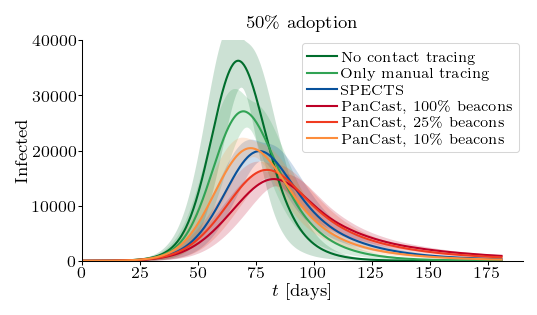

In [9]:
def plot_over_time_section_manual(*, country, area, quantity, mode, beacon_proportions, p_adoption=0.25, ymax, 
                                  rt_plots=True, commithash=None):

    p_recall = 0.1
    p_manual_reachability = 0.5
    delta_manual_tracing = 0.0
    show_spect_with_beacons = False
    beacon_mode = 'visit_freq'
    
    paths = [f'spect-tracing-{country}-{area}-{commithash}/'
                     f'spect-tracing-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall=0.0'
                     f'-p_manual_reachability=0.0'
                     f'-delta_manual_tracing=0.0'
                     f'.pk',
        
        
            f'spect-tracing-{country}-{area}-{commithash}/'
                     f'spect-tracing-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall=0.1'
                     f'-p_manual_reachability=0.5'
                     f'-delta_manual_tracing=0.0'
                     '.pk',
             
             f'spect-tracing-{country}-{area}-{commithash}/'
                 f'spect-tracing-{country}-{area}'
                 f'-p_adoption={p_adoption}'
                 f'-p_recall={p_recall}'
                 f'-p_manual_reachability={p_manual_reachability}'
                 f'-delta_manual_tracing={delta_manual_tracing}'
                 '.pk']
    
    labels = ['No contact tracing', 'Only manual tracing', 'SPECTS']
    colors = [baseline_colors[2], baseline_colors[0], spect_colors[0]]
    
    for i, beacon_proportion in enumerate(beacon_proportions):
        paths.append(f'pancast-tracing-{country}-{area}-{commithash}/'
              f'pancast-tracing-{country}-{area}'
              f'-p_adoption={p_adoption}'
              f'-beacon_proportion={beacon_proportion}'
              f'-beacon_mode={beacon_mode}'
              f'-p2p_beacon={show_spect_with_beacons}'
              f'-p_recall={p_recall}'
              f'-p_manual_reachability={p_manual_reachability}'
              f'-delta_manual_tracing={delta_manual_tracing}'
              '.pk')
        
        labels.append(f'PanCast, {int(beacon_proportion*100)}\% beacons')
        colors.append(pancast_colors[i])
    
    plot_filename = f'{mode}-{quantity}_over_time-main-manual-p_adoption_{p_adoption}'
    plotter = Plotter()

    plotter.compare_quantity(
        paths, 
        labels=labels,
        quantity=quantity,
        mode=mode,
        ymax=ymax,
        titles=f'{int(p_adoption *100)}\% adoption',
        colors=colors,
        filename=plot_filename, 
        figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
        figformat='neurips-double',
        legend_is_left=False,
        format=figformat)
    
    
# Figure 2b: Infected over time
plot_over_time_section_manual(
    country='GER', 
    area='TU',
    quantity='infected',    # Allowed values: ['infected', 'hosp', 'dead']
    mode='total',           # Allowed values: ['total', 'daily', 'cumulative', 'weekly incidence']
    ymax=40000,
    p_adoption=0.5,
    beacon_proportions=[1.0, 0.25, 0.1],
    rt_plots=True,
    commithash=commithash
)

!bash crop_pdfs.sh plots/total-*.pdf

## SI Figure 5b: no manual tracing experiment

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.


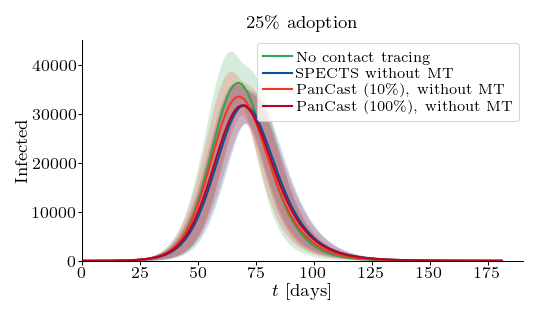

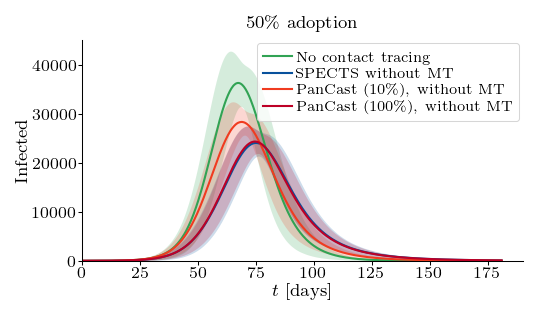

In [10]:
def plot_over_time_si_no_manual(*, country, area, quantity, mode, beacon_proportion, p_adoption=0.25, ymax, 
                                  rt_plots=True, commithash=None):

    p_recall = 0.1
    p_manual_reachability = 0.5
    delta_manual_tracing = 0.0
    show_spect_with_beacons = False
    beacon_mode = 'visit_freq'

    
    paths = [f'spect-tracing-{country}-{area}-{commithash}/'
                     f'spect-tracing-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall=0.0'
                     f'-p_manual_reachability=0.0'
                     f'-delta_manual_tracing=0.0'
                     f'.pk',
        
            f'spect-tracing-{country}-{area}-{commithash}/'
                 f'spect-tracing-{country}-{area}'
                 f'-p_adoption={p_adoption}'
                 f'-p_recall=0.0'
                 f'-p_manual_reachability=0.0'
                 f'-delta_manual_tracing=0.0'
                 '.pk',
            
            f'pancast-tracing-{country}-{area}-{commithash}/'
             f'pancast-tracing-{country}-{area}'
              f'-p_adoption={p_adoption}'
              f'-beacon_proportion={beacon_proportion}'
              f'-beacon_mode={beacon_mode}'
              f'-p2p_beacon={show_spect_with_beacons}'
              f'-p_recall=0.0'
              f'-p_manual_reachability=0.0'
              f'-delta_manual_tracing=0.0'
              '.pk',
             
             
             f'pancast-tracing-{country}-{area}-{commithash}/'
             f'pancast-tracing-{country}-{area}'
              f'-p_adoption={p_adoption}'
              f'-beacon_proportion=1.0'
              f'-beacon_mode={beacon_mode}'
              f'-p2p_beacon={show_spect_with_beacons}'
              f'-p_recall=0.0'
              f'-p_manual_reachability=0.0'
              f'-delta_manual_tracing=0.0'
              '.pk',
            ]
    
    labels = ['No contact tracing',
              #'Only manual tracing',
              'SPECTS without MT',
              #'SPECTS with MT',
              f'PanCast ({int(beacon_proportion*100)}\%), without MT',
              f'PanCast (100\%), without MT',
             ]
    
    plot_filename = f'{mode}-{quantity}_over_time-no-manual-tracing-p_adoption_{p_adoption}'
    plotter = Plotter()

    colors = ['g', 'mediumseagreen', spect_colors[0], pancast_colors[0]]
    colors = [baseline_colors[0], spect_colors[0], pancast_colors[1], pancast_colors[0]] 
    
    plotter.compare_quantity(
        paths, 
        labels=labels,
        titles=f'{int(p_adoption *100)}\% adoption',
        quantity=quantity,
        mode=mode,
        ymax=ymax,
        colors=colors,
        filename=plot_filename, 
        figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
        figformat='neurips-double',
        legend_is_left=False,
        format=figformat)
    


# SI Figure 5b, no manual tracing
plot_over_time_si_no_manual(
    country='GER', 
    area='TU',
    quantity='infected',    # Allowed values: ['infected', 'hosp', 'dead']
    mode='total',           # Allowed values: ['total', 'daily', 'cumulative', 'weekly incidence']
    ymax=45000, 
    p_adoption=0.25,
    beacon_proportion=0.1,
    commithash=commithash,
    rt_plots=True,
)

plot_over_time_si_no_manual(
    country='GER', 
    area='TU',
    quantity='infected',    # Allowed values: ['infected', 'hosp', 'dead']
    mode='total',           # Allowed values: ['total', 'daily', 'cumulative', 'weekly incidence']
    ymax=45000, 
    p_adoption=0.5,
    beacon_proportion=0.1,
    commithash=commithash,
    rt_plots=True,
)

!bash crop_pdfs.sh plots/total-*.pdf

## SI Figure 7b: Interoperability

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.


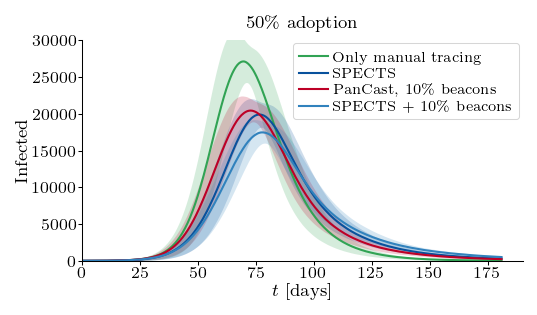

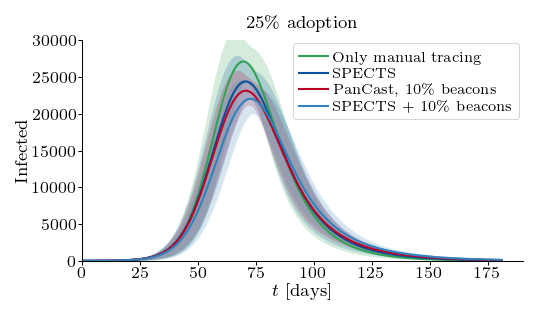

In [11]:
def plot_over_time_si_interoperability(*, country, area, quantity, mode,
                                      beacon_proportion, p_adoption=0.25, ymax=None, rt_plots=True,
                                       commithash=None):


    p_recall = 0.1
    p_manual_reachability = 0.5
    delta_manual_tracing = 0.0
    show_spect_with_beacons = False
    beacon_mode = 'visit_freq'

    paths = [
        # Baseline with MT
        f'spect-tracing-{country}-{area}-{commithash}/'
         f'spect-tracing-{country}-{area}'
         f'-p_adoption=0.0'
         f'-p_recall={p_recall}'
         f'-p_manual_reachability={p_manual_reachability}'
         f'-delta_manual_tracing={delta_manual_tracing}'
         f'.pk',
        
        # SPECTS
        f'spect-tracing-{country}-{area}-{commithash}/'
         f'spect-tracing-{country}-{area}'
         f'-p_adoption={p_adoption}'
         f'-p_recall={p_recall}'
         f'-p_manual_reachability={p_manual_reachability}'
         f'-delta_manual_tracing={delta_manual_tracing}'
         '.pk',
        
        # PanCast
        f'pancast-tracing-{country}-{area}-{commithash}/'
        f'pancast-tracing-{country}-{area}'
          f'-p_adoption={p_adoption}'
          f'-beacon_proportion={beacon_proportion}'
          f'-beacon_mode={beacon_mode}'
          f'-p2p_beacon=False'
          f'-p_recall={p_recall}'
          f'-p_manual_reachability={p_manual_reachability}'
          f'-delta_manual_tracing={delta_manual_tracing}'
          '.pk',
        
        # SPECTS + beacons
        f'pancast-tracing-{country}-{area}-{commithash}/'
        f'pancast-tracing-{country}-{area}'
          f'-p_adoption={p_adoption}'
          f'-beacon_proportion={beacon_proportion}'
          f'-beacon_mode={beacon_mode}'
          f'-p2p_beacon=True'
          f'-p_recall={p_recall}'
          f'-p_manual_reachability={p_manual_reachability}'
          f'-delta_manual_tracing={delta_manual_tracing}'
          '.pk',
    ]
    
    labels = ['Only manual tracing',
             'SPECTS',
             f'PanCast, {int(beacon_proportion*100)}\% beacons',
             f'SPECTS + {int(beacon_proportion*100)}\% beacons',
             ]
    
    colors = [baseline_colors[0], spect_colors[0], pancast_colors[0], spect_colors[1]]

    plot_filename = f'{mode}-{quantity}_over_time-interoperability-p_adoption_{p_adoption}'
    plotter = Plotter()

    plotter.compare_quantity(
        paths, 
        labels=labels,
        titles=f'{int(p_adoption *100)}\% adoption',
        quantity=quantity,
        mode=mode,
        ymax=ymax,
        colors=colors,
        filename=plot_filename, 
        figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
        figformat='neurips-double',
        legend_is_left=False,
        format=figformat)
    


# SI Figure 7b, interoperation
plot_over_time_si_interoperability(
    country='GER', 
    area='TU',
    quantity='infected',    # Allowed values: ['infected', 'hosp', 'dead']
    mode='total',           # Allowed values: ['total', 'daily', 'cumulative', 'weekly incidence']
    ymax=30000, 
    p_adoption=0.5,
    beacon_proportion=0.1,
    commithash=commithash,
    rt_plots=True
)

plot_over_time_si_interoperability(
    country='GER', 
    area='TU',
    quantity='infected',    # Allowed values: ['infected', 'hosp', 'dead']
    mode='total',           # Allowed values: ['total', 'daily', 'cumulative', 'weekly incidence']
    ymax=30000, 
    p_adoption=0.25,
    beacon_proportion=0.1,
    commithash=commithash,
    rt_plots=True
)

!bash crop_pdfs.sh plots/total-*.pdf

## SI Figure 4: Manual tracing delay

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.


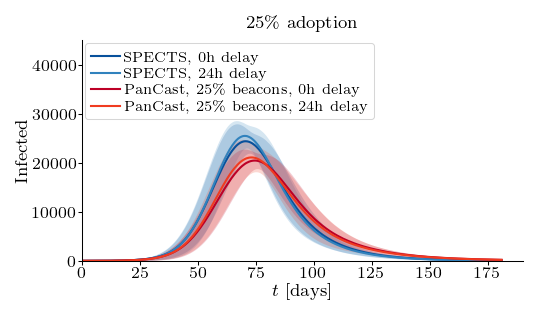

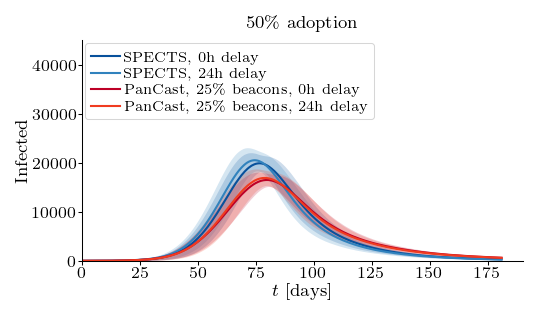

In [12]:
def plot_over_time_si_mt_delay(*, country, area, quantity, mode, manual_tracing_delays,
                               beacon_proportion, p_adoption=0.25, ymax=None, rt_plots=True, commithash=None):

    p_recall = 0.1
    p_manual_reachability = 0.5
    show_spect_with_beacons = False
    beacon_mode = 'visit_freq'

    paths = []
    labels = []
    
    for delta_manual_tracing in manual_tracing_delays:
        paths.append(f'spect-tracing-{country}-{area}-{commithash}/'
                     f'spect-tracing-{country}-{area}'
                     f'-p_adoption={p_adoption}'
                     f'-p_recall={p_recall}'
                     f'-p_manual_reachability={p_manual_reachability}'
                     f'-delta_manual_tracing={delta_manual_tracing}'
                     '.pk')
    
        labels.append(f'SPECTS, {int(delta_manual_tracing)}h delay')
    
    for delta_manual_tracing in manual_tracing_delays:
        paths.append(f'pancast-tracing-{country}-{area}-{commithash}/'
              f'pancast-tracing-{country}-{area}'
              f'-p_adoption={p_adoption}'
              f'-beacon_proportion={beacon_proportion}'
              f'-beacon_mode={beacon_mode}'
              f'-p2p_beacon={show_spect_with_beacons}'
              f'-p_recall={p_recall}'
              f'-p_manual_reachability={p_manual_reachability}'
              f'-delta_manual_tracing={delta_manual_tracing}'
              '.pk')
        
        labels.append(f'PanCast, {int(beacon_proportion*100)}\% beacons, {int(delta_manual_tracing)}h delay')
    
    plot_filename = f'{mode}-{quantity}_over_time-manual-delay-p_adoption_{p_adoption}'
    plotter = Plotter()

    colors = [spect_colors[0], spect_colors[1], pancast_colors[0], pancast_colors[1]]
    
    plotter.compare_quantity(
        paths, 
        labels=labels,
        titles=f'{int(p_adoption *100)}\% adoption',
        quantity=quantity,
        mode=mode,
        ymax=ymax,
        colors=colors,
        filename=plot_filename, 
        figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
        figformat='neurips-double',
        legend_is_left=True,
        format=figformat)
    
    
# SI Figure 4, manual tracing delay
plot_over_time_si_mt_delay(
    country='GER', 
    area='TU',
    quantity='infected',    # Allowed values: ['infected', 'hosp', 'dead']
    mode='total',           # Allowed values: ['total', 'daily', 'cumulative', 'weekly incidence']
    ymax=45000, 
    manual_tracing_delays=[0.0,24.0],
    p_adoption=0.25,
    beacon_proportion=0.25,
    commithash=commithash,
)

plot_over_time_si_mt_delay(
    country='GER', 
    area='TU',
    quantity='infected',    # Allowed values: ['infected', 'hosp', 'dead']
    mode='total',           # Allowed values: ['total', 'daily', 'cumulative', 'weekly incidence']
    ymax=45000, 
    manual_tracing_delays=[0.0,24.0],
    p_adoption=0.5,
    beacon_proportion=0.25,
    commithash=commithash,
)

!bash crop_pdfs.sh plots/total-*.pdf

# Main Figure 3

## Main Figure 3a: Reduction of infections

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previou

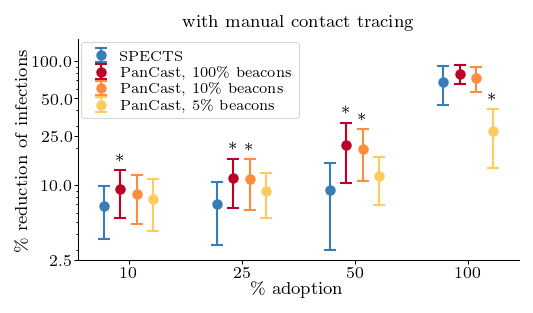

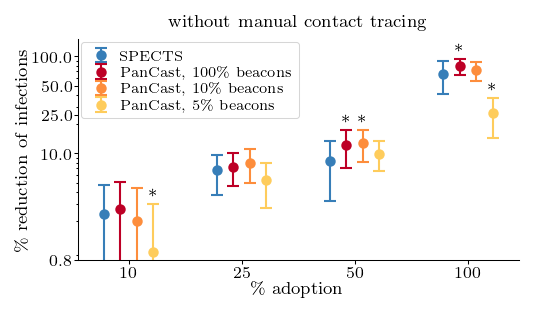

In [13]:
def plot_relative_reduction_multiple_summaries(*, country, area, mode, ps_adoption, beacon_proportions, beacon_mode='visit_freq', 
                            manual_tracing=True, show_reduction=True, show_spect_with_beacons=False,
                            colors=None, log_yscale=False, figsize=None, summary_indices=[1,2,3,4,5],
                            isolation_cap=None, ylim=None, box_plot=False, legend_is_left=True,
                            show_significance=False, sig_options=None, title=None, commithash=None):
    
    ps_adoption = np.sort(ps_adoption)
    
    if figsize is None:
        figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL
        
    if manual_tracing:
        p_recall = 0.1
        p_manual_reachability = 0.5
    else:
        p_recall = 0.0
        p_manual_reachability = 0.0
    delta_manual_tracing = 0.0
        
    if mode == 'r_eff':
        if area == 'TU':
            from lib.settings.town_settings_tubingen import town_population
        else:
            raise NotImplementedError('Specify town population')
    else:
        town_population = None
        
    if isolation_cap is not None:
        is_site_info = '-siteinfo'
        extension = (f'-beta_dispersion=10.0'
                    f'-isolation_cap={isolation_cap}'
                    f'-normalization=1.75')
        baseline_extension = (f'-beta_dispersion=10.0'
                    f'-isolation_cap=0.0'
                    f'-normalization=1.75')
    else:
        is_site_info = ''
        extension = ''
        baseline_extension = ''
        

        
    if ylim is None:
        if mode == 'r_eff' and show_reduction:
            ylim = (0.0, 50)
        elif mode == 'r_eff' and not show_reduction:
            ylim= (1.0, 3.7)
            
    
    plot_filename = (f'comparison{is_site_info}-multi-{mode}-{country}-{area}'
                    f'-reduction={show_reduction}'
                    f'-box_plot={box_plot}'
                    f'-beacon_mode={beacon_mode}'
                    f'-manual_tracing={manual_tracing}'
                    f'-p2p+beacons={show_spect_with_beacons}')
    paths = [
                [[f'spect-tracing{is_site_info}-{idx}-{country}-{area}-{commithash}/'
                 f'spect-tracing{is_site_info}-{idx}-{country}-{area}'
                 f'-p_adoption={p_adoption}'
                 f'-p_recall={p_recall}'
                 f'-p_manual_reachability={p_manual_reachability}'
                 f'-delta_manual_tracing={delta_manual_tracing}'
                 f'{extension}'
                 '.pk' for idx in summary_indices] 
                      for p_adoption in ps_adoption]
            ]
    labels = ['SPECTS']
    
    for beacon_proportion in beacon_proportions:
        paths.append([[f'pancast-tracing{is_site_info}-{idx}-{country}-{area}-{commithash}/'
                      f'pancast-tracing{is_site_info}-{idx}-{country}-{area}'
                      f'-p_adoption={p_adoption}'
                      f'-beacon_proportion={beacon_proportion}'
                      f'-beacon_mode={beacon_mode}'
                      f'-p2p_beacon={show_spect_with_beacons}'
                      f'-p_recall={p_recall}'
                      f'-p_manual_reachability={p_manual_reachability}'
                      f'-delta_manual_tracing={delta_manual_tracing}'
                      f'{extension}'
                      '.pk' for idx in summary_indices] 
                      for p_adoption in ps_adoption])
                     
        labels.append(f'PanCast, {int(beacon_proportion*100)}\% beacons')
    
    if manual_tracing:
        labels.append('Only manual tracing')
    else:
        labels.append('No tracing')
    
    
    if show_spect_with_beacons:
        # titles = [f'SPECTS + beacons at {int(beacon_proportion*100)}\% of sites' for beacon_proportion in ([0] + beacon_proportions[::-1])]
        labels = [f'SPECTS + {int(beacon_proportion*100)}\% beacons' for beacon_proportion in ([0] + beacon_proportions[::-1])]
        new_paths = paths[1:]
        paths = [paths[0]] + new_paths[::-1]
        colors = ['#377eb8', '#fecc5c', '#fd8d3c', '#f03b20', '#bd0026']
        if manual_tracing:
            labels.append('Only manual tracing')
        else:
            labels.append('No tracing')


    if isolation_cap is not None:
        # Always normalize with no MT baseline
        p_recall = 0.0
        p_manual_reachability = 0.0
        
    baseline_path = [f'spect-tracing{is_site_info}-{idx}-{country}-{area}-{commithash}/'
                     f'spect-tracing{is_site_info}-{idx}-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall={p_recall}'
                     f'-p_manual_reachability={p_manual_reachability}'
                     f'-delta_manual_tracing={delta_manual_tracing}'
                     f'{extension}'
                     f'.pk' for idx in summary_indices]

    plotter = Plotter()
    plotter.compare_peak_reduction(path_list=paths, 
                                   baseline_path=baseline_path, 
                                   ps_adoption=ps_adoption,
                                   area_population=town_population,
                                   labels=labels,
                                   title=title,
                                   mode=mode,
                                   show_reduction=show_reduction,
                                   combine_summaries=True,
                                   box_plot=box_plot,
                                   log_xscale=True,
                                   log_yscale=log_yscale,
                                   show_significance=show_significance,
                                   sig_options=sig_options,
                                   ylim=ylim,
                                   colors=colors,
                                   filename=plot_filename,
                                   figsize=figsize,
                                   figformat='neurips-double',
                                   legend_is_left=legend_is_left,
                                   format=figformat)


    
# Main figure 3a), environmental information
sig_options = {'lhs_xshift': 0.013, 
            'rhs_xshift': 0.13, 
            'height': 0.1,
           'same_height': False}

for manual_tracing, title in zip([True, False], ['with manual contact tracing', 'without manual contact tracing']):
    if manual_tracing:
        ylim = [2.5,150]
    else:
        ylim = [0.8, 150]
    
    plot_relative_reduction_multiple_summaries(
        country='GER', 
        area='TU', 
        mode='cumu_infected',
        title=title,
        ps_adoption=[1.0, 0.5, 0.25, 0.1],
        beacon_proportions=[1.0, 0.1, 0.05],
        summary_indices=[1, 2, 3, 5],
        isolation_cap=0.1,
        manual_tracing=manual_tracing,
        show_spect_with_beacons=False,
        colors=['#377eb8', '#bd0026', '#fd8d3c', '#fecc5c', '#ffffb2'],
        ylim=ylim,
        show_significance='no_bars',
        sig_options=sig_options,
        box_plot=True,
        log_yscale=True,
        commithash='32717f3'
    )
    
!bash crop_pdfs.sh plots/comparison-*.pdf

## Main Figure 3b) & 3d): ROC

None
Loaded previously extracted data.
index 1 : 0.0 - 0.2
index 2 : 0.2 - 0.4
index 3 : 0.4 - 0.6000000000000001
index 4 : 0.6000000000000001 - 0.8
index 5 : 0.8 - 1.0
Maximum relative % PanCast/SPECT (excluding boundary) tpr 123.7866116677296 bin:  2
Maximum relative % PanCast/SPECT (excluding boundary) prec 124.29351792765921 bin:  2
[0.5, 0.25, 0.1, 0.05]
Loaded previously extracted data.
index 1 : 0.0 - 0.2
index 2 : 0.2 - 0.4
index 3 : 0.4 - 0.6000000000000001
index 4 : 0.6000000000000001 - 0.8
index 5 : 0.8 - 1.0
Could not compute Maximum relative % PanCast/SPECT (excluding boundary)
Could not compute Maximum relative % PanCast/SPECT (excluding boundary)
Loaded previously extracted data.
index 1 : 0.0 - 0.2
index 2 : 0.2 - 0.4
index 3 : 0.4 - 0.6000000000000001
index 4 : 0.6000000000000001 - 0.8
index 5 : 0.8 - 1.0
Could not compute Maximum relative % PanCast/SPECT (excluding boundary)
Could not compute Maximum relative % PanCast/SPECT (excluding boundary)
Loaded previously extr

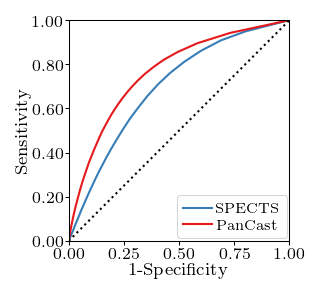

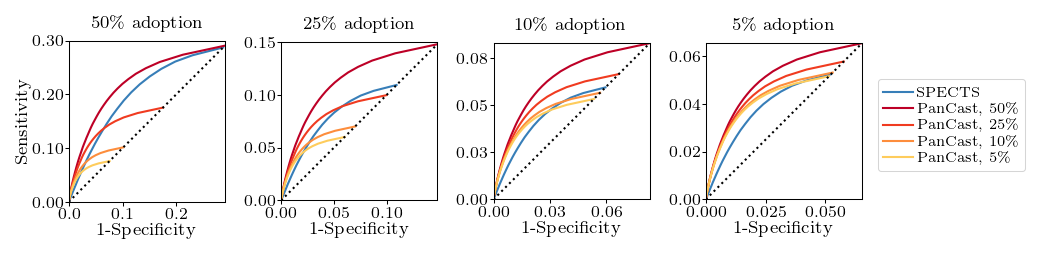

In [14]:
def plot_roc(*, country, area, p_adoption, p_beacon, beta_dispersions, manual_tracing, sitetype=None, 
             multiplot=False, commithash=None):
    
    for beta_dispersion in beta_dispersions:
        path = (f'beacon-environment-{country}-{area}-{commithash}/'
                          f'beacon-environment-{country}-{area}'
                          f'-beacon=all'
                          f'-p_adoption=1.0'
                          f'-beta_dispersion={beta_dispersion}'
                          '.pk')

        if p_adoption is not None:
            if manual_tracing:
                p_manual_reachability = 0.5
                p_recall = 0.1
            else:
                p_manual_reachability = 0.0
                p_recall = 0.0
        else:
            p_manual_reachability = None
            p_recall = None
            p_beacon = None
            p_adoption = [None]

        if multiplot:
            # figsize = (8,3)
            LINE_WIDTH = 7.0
            COL_WIDTH = 3.333
            figsize = (LINE_WIDTH, LINE_WIDTH / 3 * 4.5/6)
            ps_adoption = [p_adoption]
        else:
            # figsize = (2.0, 1.8)
            LINE_WIDTH = 7.0
            COL_WIDTH = 3.333
            figsize = (LINE_WIDTH / 2, 1.15 * LINE_WIDTH / 3 * 4.5/6)
            #figsize = lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL
            ps_adoption = p_adoption
            
        for p_adoption in ps_adoption:
            print(p_adoption)
            plot_filename = f'ROC-{country}-{area}-multiplot-{multiplot}-manual-tracing={manual_tracing}-beta-dispersion={beta_dispersion}'
            plotter = Plotter()

            plotter.plot_roc_curve(
                summaries=None,
                paths=[path],
                filename=plot_filename, 
                p_adoption=p_adoption,
                p_manual_reachability=p_manual_reachability,
                p_recall=p_recall,
                p_beacon=p_beacon,
                sitetype=sitetype,
                action='isolate',
                figsize=figsize, 
                figformat='neurips-double',
                verbose=False,
                use_medical_labels=True,
                format=figformat)


# Figure 3b)
plot_roc(
    country='GER', 
    area='TU', 
    p_adoption=None,
    p_beacon=None,
    sitetype=None,
    beta_dispersions=[10.0],
    manual_tracing=True,
    multiplot=False,
    commithash='43d4464'
)

# Figure 3d)
plot_roc(
    country='GER', 
    area='TU', 
    p_adoption=[0.5, 0.25, 0.1, 0.05],
    p_beacon=[0.5, 0.25, 0.1, 0.05],
    beta_dispersions=[10.0],
    manual_tracing=True,
    multiplot=True,
    commithash='43d4464'
)
    
# # Crop pdf margins
!bash crop_pdfs.sh plots/ROC-*.pdf

## Main Figure 3c): ROC per sitetype

Loaded previously extracted data.

PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.


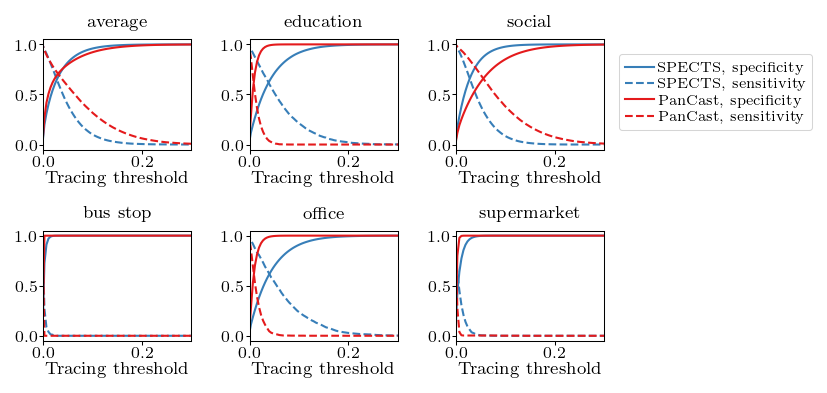

In [15]:
def plot_sens_spec_per_sitetype(beta_dispersion = 10.0, commithash=None):
    summary = load_condensed_summary(f'beacon-environment-GER-TU-{commithash}/'
                              f'beacon-environment-GER-TU'
                              f'-beacon=all'
                              f'-p_adoption=1.0'
                              f'-beta_dispersion={beta_dispersion}'
                              '.pk')
    print()

    tracing_stats = summary['tracing_stats']
    thresholds = list(tracing_stats.keys())
    thres = thresholds[0]

    results = {'sites': defaultdict(lambda: {'fpr': [], 'tpr': []}),
              'no_sites': defaultdict(lambda: {'fpr': [], 'tpr': []})}

    # Compute FPR, TPR
    for sites in ['no_sites', 'sites']:
        for sitetype in tracing_stats[thres].keys():
            for thres in thresholds:
                infected = tracing_stats[thres][sitetype][sites]['isolate']['tp'].mean() + tracing_stats[thres][sitetype][sites]['isolate']['fn'].mean()
                not_infected = tracing_stats[thres][sitetype][sites]['isolate']['tn'].mean() + tracing_stats[thres][sitetype][sites]['isolate']['fp'].mean()
                isolated = tracing_stats[thres][sitetype][sites]['isolate']['tp'].mean() + tracing_stats[thres][sitetype][sites]['isolate']['fp'].mean()
                not_isolated = tracing_stats[thres][sitetype][sites]['isolate']['fn'].mean() + tracing_stats[thres][sitetype][sites]['isolate']['tn'].mean()
                tpr = tracing_stats[thres][sitetype][sites]['isolate']['tp'].mean() / infected
                fpr = tracing_stats[thres][sitetype][sites]['isolate']['fp'].mean() / not_infected
                results[sites][sitetype]['fpr'].append(fpr)
                results[sites][sitetype]['tpr'].append(tpr)

    # Plot per site type
    
    LINE_WIDTH = 7.0
    COL_WIDTH = 3.333
    # figsize = (0.9*LINE_WIDTH  ,0.9 * 1.7 * LINE_WIDTH / 3 * 4.5/6)
    figsize = (0.8*LINE_WIDTH  ,0.9 * 1.7 * LINE_WIDTH / 3 * 4.5/6)
    
    fig, ax = plt.subplots(2, 3, figsize=figsize)#(16,1.5))
    
    keys = list(tracing_stats[thres].keys())
    keys = np.roll(keys, 1)
    # keys = ['bus_stop', 'social', 'education', 'office', 'supermarket', 'stats']
    for i, sitetype in enumerate(keys):
        for k, sites in enumerate(['no_sites', 'sites']):
            if sites == 'sites':
                label = 'PanCast'
                color = '#e41a1c'
            else:
                label = 'SPECTS'
                color = '#377eb8'
                
            ax.flat[i].plot(thresholds, 1- np.asarray(results[sites][sitetype]['fpr']), label=label+', specificity', color=color)
            ax.flat[i].plot(thresholds, results[sites][sitetype]['tpr'], label=label+', sensitivity', color=color, linestyle='dashed')
            ax.flat[i].set_xlim([0,0.3])
            title = 'bus stop' if sitetype == 'bus_stop' else sitetype
            title = 'average' if sitetype == 'stats' else title
            ax.flat[i].set_title(title)
            ax.flat[i].set_xlabel('Tracing threshold')

                
    ax[0,2].legend(loc='lower left', bbox_to_anchor=(1.1, 0.18),
                      borderaxespad=0, frameon=True)

                
    filename = f'site-dependent-characteristics-beta_dispersion={beta_dispersion}'
    plt.tight_layout()
    plt.savefig('plots/' + filename + f'.{figformat}', format=figformat, facecolor=None,
                        dpi=300, bbox_inches='tight')


    
# Figure 3c)
plot_sens_spec_per_sitetype(commithash='43d4464')
!bash crop_pdfs.sh plots/site-dependent-*.pdf

# Main Figure 4: strategic beacon location

## Main Figure 4a: reduction of infections

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previou

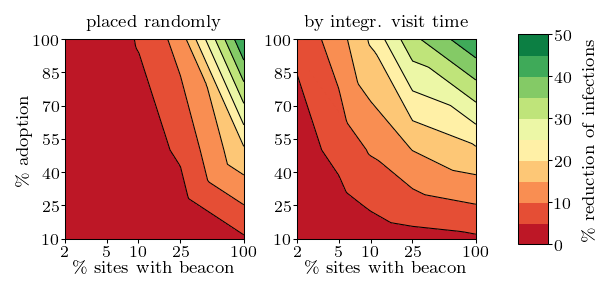

In [16]:
def plot_relative_quantity_heatmap_beacon_mode(*, country, area, mode,
    ps_adoption, beacon_proportions, interpolate, cmap):
    
    filename = (
        f'relative-{mode}-heatmap-pancast'
    )
        
        
    baseline_path = (f'spect-tracing-{country}-{area}-{commithash}/'
                 f'spect-tracing-{country}-{area}'
                 f'-p_adoption=0.0'
                 f'-p_recall=0.1'
                 f'-p_manual_reachability=0.5'
                 f'-delta_manual_tracing=0.0'
                 f'.pk')
    
    # pair of list of tuples (x, y, path)
    paths = (
        # spect
        [(beacon_proportion, p_adoption, 
         (f'pancast-tracing-{country}-{area}-{commithash}/'
          f'pancast-tracing-{country}-{area}'
          f'-p_adoption={p_adoption}'
          f'-beacon_proportion={beacon_proportion}'
          f'-beacon_mode=random'
          f'-p2p_beacon=False'
          f'-p_recall=0.1'
          f'-p_manual_reachability=0.5'
          f'-delta_manual_tracing=0.0'
          f'.pk'))
         
        for p_adoption in ps_adoption
        for beacon_proportion in beacon_proportions],
        
        # pancast
        [(beacon_proportion, p_adoption, 
         (f'pancast-tracing-{country}-{area}-{commithash}/'
          f'pancast-tracing-{country}-{area}'
          f'-p_adoption={p_adoption}'
          f'-beacon_proportion={beacon_proportion}'
          f'-beacon_mode=visit_freq'
          f'-p2p_beacon=False'
          f'-p_recall=0.1'
          f'-p_manual_reachability=0.5'
          f'-delta_manual_tracing=0.0'
          f'.pk'))
         
        for p_adoption in ps_adoption
        for beacon_proportion in beacon_proportions]
    )

    # plots
    plotter = Plotter()
    plotter.relative_quantity_heatmap(
        xlabel=r'\% sites with beacon',
        ylabel=r'\% adoption',
        path_labels=['placed randomly', 'by integr. visit time'],
        paths=paths, 
        mode=mode,
        zmax=50,
        baseline_path=baseline_path,
        filename=filename, 
#         figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
        figsize=(4.0, 2.0), 
        figformat='neurips-double',
        interpolate=interpolate,
        width_ratio=1,
        cmap=cmap,
        format=figformat,
    )


# Main Figure 4a)
for mode in ["cumu_infected"]:
    plot_relative_quantity_heatmap_beacon_mode(
        mode=mode,
        country='GER', 
        area='TU', 
        ps_adoption=[0.1, 0.25, 0.5, 1.0],
        beacon_proportions=[1.0, 0.25, 0.1, 0.05, 0.02],
        interpolate='linear',
        cmap=plt.cm.RdYlGn,
    )

!bash crop_pdfs.sh plots/relative-*.pdf

## Main Figure 4b), 4c): Beacon locations maps

In [17]:
from lib.mobilitysim import MobilitySimulator
from lib.town_maps import MapIllustrator
import importlib
from folium.folium import Map
from folium import CircleMarker

def show_beacon_distribution(beacon_mode, beacon_proportion):

    beacon_config = dict(mode=beacon_mode, proportion_with_beacon=beacon_proportion)
    mob_settings_file = 'lib/mobility/Tubingen_settings_1.pk'

    with open(mob_settings_file, 'rb') as fp:
        mob_settings = pickle.load(fp)

    mob_settings['beacon_config'] = beacon_config
    mob = MobilitySimulator(**mob_settings)

    ill = MapIllustrator()
    ill.marker_radius = 3.0
    bbox = importlib.import_module(f'lib.settings.town_settings_tubingen').bbox

    # center map around the given bounding box
    center = ((bbox[0]+bbox[1])/2,(bbox[2]+bbox[3])/2)
    m = Map(location=center,tiles=ill.tile)
    m.fit_bounds([(bbox[0],bbox[2]),(bbox[1],bbox[3])])

    # set marker labels as site types
    labels = [mob.site_dict[site] for site in mob.site_type]
    color_map = matplotlib.cm.get_cmap('tab10')

    for i_marker, marker in enumerate(mob.site_loc):

        if not mob.site_has_beacon[i_marker]:
            color = 'darkgrey'
            opacity = 0.5
            fill_opacity = 1.0

            CircleMarker(
                location = marker, 
                radius = ill.marker_radius,
                color=color,
                fill_color=color,
                opacity=opacity,
                fill_opacity=fill_opacity,
                popup=labels[i_marker],
            ).add_to(m)
            
    for i_marker, marker in enumerate(mob.site_loc):

        if mob.site_has_beacon[i_marker]:
            color = matplotlib.colors.rgb2hex(color_map(mob.site_type[i_marker]))
            opacity = 0.7
            fill_opacity = 1.0
            
            CircleMarker(
                location = marker, 
                radius = ill.marker_radius,
                color=color,
                fill_color=color,
                opacity=opacity,
                fill_opacity=fill_opacity,
                popup=labels[i_marker],
            ).add_to(m)
        

    map_name = f'map-{beacon_mode}-beacons={beacon_proportion}'
    if not os.path.exists('maps'):
        os.mkdir('maps')
    m.save('maps/'+map_name+'.html')
    
for beacon_mode in ['visit_freq', 'random']:
    show_beacon_distribution(beacon_mode=beacon_mode, beacon_proportion=0.25)

# SI Plots

## R_t over time

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Save: plots/rt-main-manual.tiff
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Save: plots/rt-no-manual.tiff
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Save: plots/rt-interoperation.tiff
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.


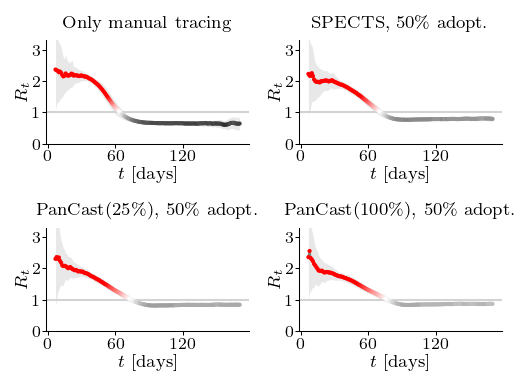

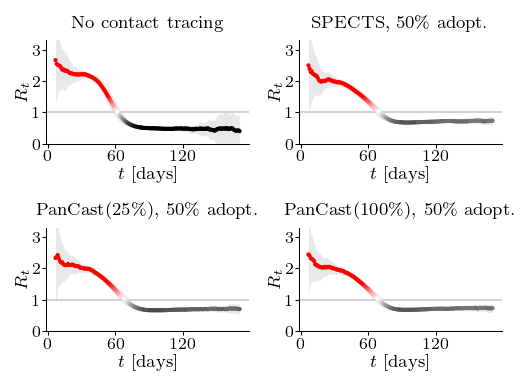

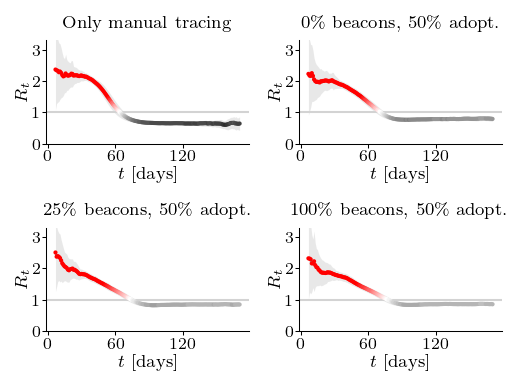

In [18]:
def plot_rt_panel(experiment, p_adoption):
    
    country = 'GER'
    area = 'TU'
    beacon_mode = 'visit_freq'
    
    if experiment == 'no-manual':
        p_recall = 0.0
        p_manual_reachability = 0.0
    else:
        p_recall = 0.1
        p_manual_reachability = 0.5
    delta_manual_tracing = 0.0
    
    if experiment == 'interoperation':
        show_spect_with_beacons = True
    else:
        show_spect_with_beacons = False
 
    
    
    paths = [f'spect-tracing-{country}-{area}-{commithash}/'
                     f'spect-tracing-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall={p_recall}'
                     f'-p_manual_reachability={p_manual_reachability}'
                     f'-delta_manual_tracing=0.0'
                     '.pk',

             f'spect-tracing-{country}-{area}-{commithash}/'
                 f'spect-tracing-{country}-{area}'
                 f'-p_adoption={p_adoption}'
                 f'-p_recall={p_recall}'
                 f'-p_manual_reachability={p_manual_reachability}'
                 f'-delta_manual_tracing={delta_manual_tracing}'
                 '.pk',

            f'pancast-tracing-{country}-{area}-{commithash}/'
          f'pancast-tracing-{country}-{area}'
          f'-p_adoption={p_adoption}'
          f'-beacon_proportion=0.25'
          f'-beacon_mode={beacon_mode}'
          f'-p2p_beacon={show_spect_with_beacons}'
          f'-p_recall={p_recall}'
          f'-p_manual_reachability={p_manual_reachability}'
          f'-delta_manual_tracing={delta_manual_tracing}'
          '.pk',


            f'pancast-tracing-{country}-{area}-{commithash}/'
          f'pancast-tracing-{country}-{area}'
          f'-p_adoption={p_adoption}'
          f'-beacon_proportion=1.0'
          f'-beacon_mode={beacon_mode}'
          f'-p2p_beacon={show_spect_with_beacons}'
          f'-p_recall={p_recall}'
          f'-p_manual_reachability={p_manual_reachability}'
          f'-delta_manual_tracing={delta_manual_tracing}'
          '.pk'

            ]
        
    if experiment == 'main-manual':
        labels = [f'Only manual tracing', 
                  f'SPECTS, {int(p_adoption*100)}\% adopt.',
                 f'PanCast(25\%), {int(p_adoption*100)}\% adopt.',
                 f'PanCast(100\%), {int(p_adoption*100)}\% adopt.']
    elif experiment == 'no-manual':
        labels = [f'No contact tracing', 
                  f'SPECTS, {int(p_adoption*100)}\% adopt.',
                  f'PanCast(25\%), {int(p_adoption*100)}\% adopt.',
                  f'PanCast(100\%), {int(p_adoption*100)}\% adopt.']
    elif experiment == 'interoperation':
        labels = [f'Only manual tracing', 
                  f'0\% beacons, {int(p_adoption*100)}\% adopt.',
                  f'25\% beacons, {int(p_adoption*100)}\% adopt.',
                  f'100\% beacons, {int(p_adoption*100)}\% adopt.']

    
    names = [f'baseline', 
         f'SPECTS-p_adoption={p_adoption}',
         f'beacons=0.25-p_adoption={p_adoption}',
         f'beacons=0.100-p_adoption={p_adoption}',
        ]
        
    #_, filename = os.path.split(path)
    plot_filename = 'rt-' + experiment


    LINE_WIDTH = 7.0
    COL_WIDTH = 3.333
    figsize = (0.5*LINE_WIDTH,  1.5 * LINE_WIDTH / 3 * 4.5/6)
    
    
    # plot
    plotter = Plotter()
    plotter.plot_daily_nbinom_rts_panel(
        paths=paths, 
        titles=labels,
        filename=plot_filename,
        cmap_range=(0.5, 1.5),
        figsize=figsize,
        figformat='neurips-double',
        ymax=3.3,
        #xlim=(0, 185),
        x_axis_dates=False,
        show_legend=False,
        subplots_adjust={'bottom':0.2, 'top': 0.98, 'left': 0.12, 'right': 0.96},
        format=figformat
    )

    
# SI Figure 2
plot_rt_panel(experiment='main-manual', 
        p_adoption=0.5)

# SI Figure 5c
plot_rt_panel(experiment='no-manual', 
        p_adoption=0.5)

# SI Figure 7c
plot_rt_panel(experiment='interoperation', 
        p_adoption=0.5)

!bash crop_pdfs.sh plots/rt-*.pdf

## SI Figure 3a): Manual tracing senitivity heatmaps

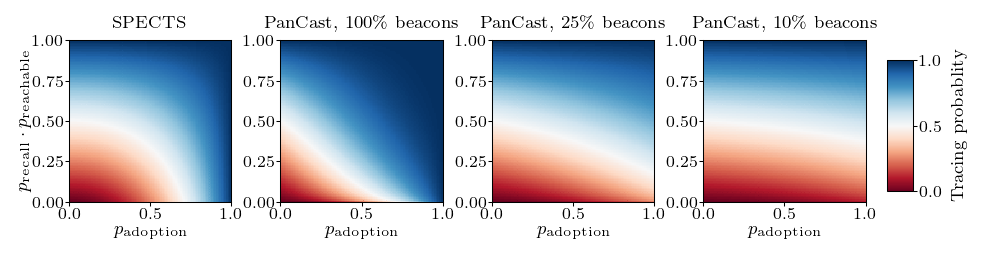

PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.


In [19]:
def plot_tracing_probability2(mode, ps_beacon):
    LINE_WIDTH = 7.0
    COL_WIDTH = 3.333
    figsize = (LINE_WIDTH, LINE_WIDTH / 3 * 4.5/6)
    
    fig, axs = plt.subplots(1, 1+len(ps_beacon), figsize=figsize)

    p_recall_reachability, p_adoption = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
    p_recall = np.sqrt(p_recall_reachability)
    p_reachable = np.sqrt(p_recall_reachability)
    
    # SPECTS
    p_tracable = get_tracing_probability('SPECTS', p_adoption=p_adoption, p_manual_reachability=p_reachable, p_recall=p_recall)
    c = axs[0].pcolormesh(p_adoption, p_recall_reachability, p_tracable, cmap='RdBu', vmin=0.0, vmax=1.0, linewidth=0, rasterized=True)
    axs[0].set_title('SPECTS')
    axs[0].set_ylabel(r'$p_{\rm recall} \cdot p_{\rm reachable}$')
    axs[0].set_xlabel(r'$p_{\rm adoption}$')
    
    # PanCast
    for k, p_beacon in enumerate(ps_beacon):
        p_tracable = get_tracing_probability('PanCast', p_adoption=p_adoption, p_manual_reachability=p_reachable, p_recall=p_recall, p_beacon=p_beacon)
        c = axs[k+1].pcolor(p_adoption, p_recall_reachability, p_tracable, cmap='RdBu', vmin=0.0, vmax=1.0, linewidth=0, rasterized=True)
        axs[k+1].set_title(f'PanCast, {int(p_beacon*100)}\% beacons')
        # axs[k+1].set_ylabel(r'$p_{\rm recall} \cdot p_{\rm reachablity}$')
        axs[k+1].set_xlabel(r'$p_{\rm adoption}$')

    fig.tight_layout()
    fig.subplots_adjust(right=0.82)

    cbar_ax = fig.add_axes([0.84, 0.255, 0.025, 0.5])
    cbar = matplotlib.colorbar.ColorbarBase(
        cbar_ax, cmap=plt.cm.RdBu,
        norm=colors.Normalize(vmin=0, vmax=1),
        orientation='vertical')
    cbar.set_label('Tracing probablity', labelpad=5.0)
    
    filename = 'tracing-prob-adoption-vs-manual'
    plt.savefig('plots/' + filename + f'.{figformat}', format=figformat, 
                facecolor=None, dpi=300)

    plt.show()
    
# SI Figure 3a)
plot_tracing_probability2(mode=None, ps_beacon=[1.0, 0.25, 0.1])
!bash crop_pdfs.sh plots/tracing-prob-*.pdf

## SI Figure 3b) - d): Manual tracing senitivity heatmaps

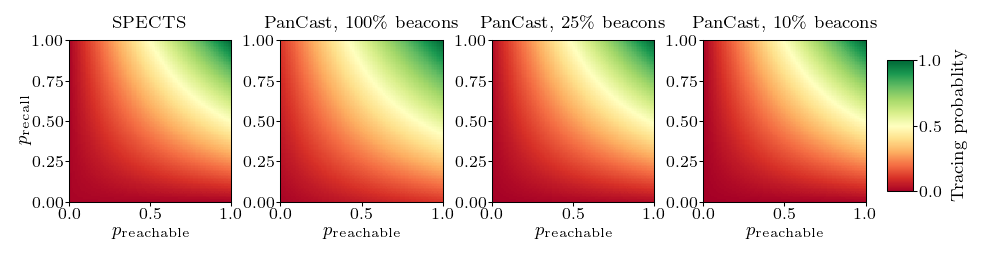

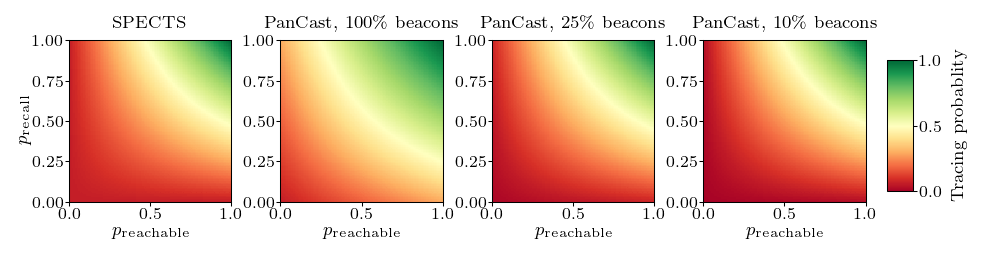

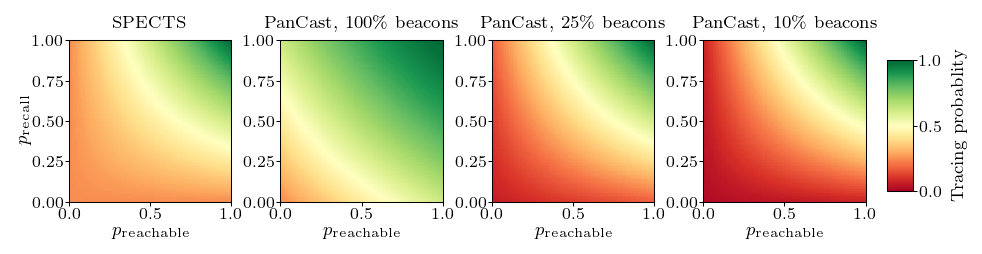

PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.


In [20]:
def plot_tracing_probability(mode, p_adoption, ps_beacon):
    LINE_WIDTH = 7.0
    COL_WIDTH = 3.333
    figsize = (LINE_WIDTH, LINE_WIDTH / 3 * 4.5/6)
    
    #fig, axs = plt.subplots(1, 1+len(ps_beacon), figsize=(3 * (1 + len(ps_beacon)), 2.5))
    fig, axs = plt.subplots(1, 1+len(ps_beacon), figsize=figsize)
    
    p_recall, p_manually_reachable = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
    
    # SPECTS
    p_tracable = get_tracing_probability('SPECTS', p_adoption=p_adoption, p_manual_reachability=p_manually_reachable, p_recall=p_recall)
    c = axs[0].pcolormesh(p_manually_reachable, p_recall, p_tracable, cmap='RdYlGn', vmin=0, vmax=1.0, linewidth=0, rasterized=True)
    axs[0].set_title('SPECTS')
    axs[0].set_ylabel(r'$p_{\rm recall}$')
    axs[0].set_xlabel(r'$p_{\rm reachable}$')
    
    # PanCast
    for k, p_beacon in enumerate(ps_beacon):
        p_tracable = get_tracing_probability('PanCast', p_adoption=p_adoption, p_manual_reachability=p_manually_reachable, p_recall=p_recall, p_beacon=p_beacon)
        c = axs[k+1].pcolormesh(p_manually_reachable, p_recall, p_tracable, cmap='RdYlGn', vmin=0, vmax=1.0, linewidth=0, rasterized=True)
        axs[k+1].set_title(f'PanCast, {int(p_beacon*100)}\% beacons')
        # axs[k+1].set_ylabel(r'$p_{\rm recall}$')
        axs[k+1].set_xlabel(r'$p_{\rm reachable}$')

    fig.tight_layout()
    fig.subplots_adjust(right=0.82)

    #cbar_ax = fig.add_axes([0.84, 0.215, 0.03, 0.66])
    cbar_ax = fig.add_axes([0.84, 0.255, 0.025, 0.5])
    cbar = matplotlib.colorbar.ColorbarBase(
        cbar_ax, cmap=plt.cm.RdYlGn,
        norm=colors.Normalize(vmin=0, vmax=1),
        orientation='vertical')
    cbar.set_label('Tracing probablity', labelpad=5.0)
    
    filename = f'tracing-prob-recall-vs-reachable-p_adoption={p_adoption}'
    plt.savefig('plots/' + filename + f'.{figformat}', format=figformat, 
                facecolor=None, dpi=300)
    plt.show()

for p_adoption in [0.1, 0.25, 0.5]:
    plot_tracing_probability(mode=None, p_adoption=p_adoption, ps_beacon=[1.0, 0.25, 0.1])

!bash crop_pdfs.sh plots/tracing-prob-*.pdf    